In [1]:
import time
from pathlib import Path
import pprint
import logging
import warnings
logger = logging.getLogger(__name__)

import numpy as np
import torch

import kilosort
from kilosort import (
    preprocessing,
    datashift,
    template_matching,
    clustering_qr,
    clustering_qr,
    io,
    spikedetect,
    CCG,
    PROBE_DIR
)
from kilosort.parameters import DEFAULT_SETTINGS
from kilosort.run_kilosort import set_files, setup_logger, initialize_ops, compute_preprocessing, compute_drift_correction, compute_preprocessing, detect_spikes, cluster_spikes, save_sorting
import json
import scipy.io as sio
from kilosort.spikedetect import extract_wPCA_wTEMP, template_match, nearest_chans, yweighted, get_waves, template_centers
from tqdm import tqdm
from io import StringIO
import matplotlib.pyplot as plt
import os

from kilosort.clustering_qr import get_data_cpu, cluster, x_centers, y_centers, xy_up
from kilosort import hierarchical, swarmsplitter 

from kilosort.clustering_qr import neigh_mat, Mstats, kmeans_plusplus, assign_isub, assign_iclust

import faiss

from scipy.sparse import csr_matrix
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.cluster.vq import kmeans

In [2]:
filename = Path(r'D:\Michael\PreprocessMotionCorrection\traces_cached_seg0.raw')
data_dir = Path(r'D:\Michael\PreprocessMotionCorrection')
results_dir = Path(r'D:\Michael\PreprocessMotionCorrection\kilosort4')
bad_channels = []
clear_cache = False
data_dtype = 'int16'
do_CAR = False
device = torch.device('cuda')
invert_sign = False
save_preprocessed_copy = False
file_object = None
save_extra_vars = False
progress_bar = None

# Configure settings, ops, and file paths
# settings = json.load(open(r'D:\Michael\PreprocessMotionCorrection\kilosort4_settings.json'))
settings = {**DEFAULT_SETTINGS}

settings['highpass_cutoff'] = 60
settings['whitening_range'] = 0
settings['nblocks'] = 0
settings['templates_from_data'] = False

print(settings)
json.dump(settings, open(r'D:\Michael\PreprocessMotionCorrection\kilosort4_settings.json', 'w'), indent=4)

{'n_chan_bin': 385, 'fs': 30000, 'batch_size': 60000, 'nblocks': 0, 'Th_universal': 9, 'Th_learned': 8, 'tmin': 0, 'tmax': inf, 'nt': 61, 'shift': None, 'scale': None, 'artifact_threshold': inf, 'nskip': 25, 'whitening_range': 0, 'highpass_cutoff': 60, 'binning_depth': 5, 'sig_interp': 20, 'drift_smoothing': [0.5, 0.5, 0.5], 'nt0min': None, 'dmin': None, 'dminx': 32, 'min_template_size': 10, 'template_sizes': 5, 'nearest_chans': 10, 'nearest_templates': 100, 'max_channel_distance': None, 'templates_from_data': False, 'n_templates': 6, 'n_pcs': 6, 'Th_single_ch': 6, 'acg_threshold': 0.2, 'ccg_threshold': 0.25, 'cluster_downsampling': 20, 'x_centers': None, 'duplicate_spike_ms': 0.25}


In [13]:
def kmeans_plusplus_numpy(Xd, niter = 200, seed = 1):
    vtot = (Xd**2).sum(1)

    n1 = vtot.shape[0]
    if n1 > 2**24:
        # Need to subsample v2, torch.multinomial doesn't allow more than 2**24
        # elements. We're just using this to sample some spikes, so it's fine to
        # not use all of them.
        n2 = n1 - 2**24   # number of spikes to remove before sampling
        remove = np.round(np.linspace(0, n1-1, n2)).astype(int)
        idx = np.ones(n1, dtype=bool)
        idx[remove] = False
        # Also need to map the indices from the subset back to indices for
        # the full tensor.
        rev_idx = idx.nonzero()[0]
        subsample = True
    else:
        subsample = False

    np.random.seed(seed)

    ntry = 100
    NN, nfeat = Xd.shape    
    mu = np.zeros((niter, nfeat))
    vexp0 = np.zeros(NN)

    iclust = np.zeros((NN,), dtype = 'int64')
    for j in tqdm(range(niter)):
        v2 = np.maximum(0, (vtot - vexp0))
        if subsample:
            # isamp = rev_idx[torch.multinomial(v2[idx], ntry)]
            isamp = np.random.choice(len(idx), size=ntry, p=v2[idx] / np.sum(v2[idx]), replace=False)
        else:
            # isamp = torch.multinomial(v2, ntry)
            isamp = np.random.choice(len(v2), size=ntry, p=v2 / np.sum(v2), replace=False)
        
        Xc = Xd[isamp]    
        vexp = 2 * Xd @ Xc.T - (Xc**2).sum(1)
        
        dexp = vexp - np.expand_dims(vexp0, axis=1)
        dexp = np.maximum(0, dexp)
        vsum = dexp.sum(0)

        imax = np.argmax(vsum)
        ix = dexp[:, imax] > 0 

        mu[j] = Xd[ix].mean(0)
        vexp0[ix] = vexp[ix,imax]
        iclust[ix] = j

In [3]:
# set probe
probe_path = Path(r'D:\Michael\chanMap.mat')
probe = sio.matlab.loadmat(probe_path)

probe = {
    'chanMap': np.squeeze(np.array(probe['chanMap']-1, dtype='int64')),
    'xc': np.squeeze(np.array(probe['xcoords'], dtype='float64')),
    'yc': np.squeeze(np.array(probe['ycoords'], dtype='float64')),
    'kcoords': np.squeeze(np.array(probe['kcoords'], dtype='int64')),
    'n_chan': int(np.squeeze(np.array(probe['xcoords'])).shape[0]),
}

probe_name = 'chanMap'
print(probe)

settings['n_chan_bin'] = probe['n_chan']

{'chanMap': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 

In [4]:
# NOTE: This modifies settings in-place
filename, data_dir, results_dir, probe = \
    set_files(settings, filename, probe, probe_name, data_dir, results_dir, bad_channels)
setup_logger(results_dir)

logger.info(f"Kilosort version {kilosort.__version__}")
logger.info(f"Sorting {filename}")
if clear_cache:
    logger.info('clear_cache=True')
logger.info('-'*40)

if data_dtype is None:
    logger.info(
        "Interpreting binary file as default dtype='int16'. If data was "
        "saved in a different format, specify `data_dtype`."
        )
    data_dtype = 'int16'

if not do_CAR:
    logger.info("Skipping common average reference.")

if device is None:
    if torch.cuda.is_available():
        logger.info('Using GPU for PyTorch computations. '
                    'Specify `device` to change this.')
        device = torch.device('cuda')
    else:
        logger.info('Using CPU for PyTorch computations. '
                    'Specify `device` to change this.')
        device = torch.device('cpu')

if probe['chanMap'].max() >= settings['n_chan_bin']:
    raise ValueError(
        f'Largest value of chanMap exceeds channel count of data, '
        'make sure chanMap is 0-indexed.'
    )

tic0 = time.time()
ops = initialize_ops(settings, probe, data_dtype, do_CAR, invert_sign,
                    device, save_preprocessed_copy)
# Remove some stuff that doesn't need to be printed twice, then pretty-print
# format for log file.
ops_copy = ops.copy()
_ = ops_copy.pop('settings')
_ = ops_copy.pop('probe')
print_ops = pprint.pformat(ops_copy, indent=4, sort_dicts=False)
logger.debug(f"Initial ops:\n{print_ops}\n")

# Set preprocessing and drift correction parameters
ops = compute_preprocessing(ops, device, tic0=tic0, file_object=file_object)
np.save(results_dir / 'ops_temp.npy', ops, allow_pickle=True)

np.random.seed(1)
torch.cuda.manual_seed_all(1)
torch.random.manual_seed(1)
ops, bfile, st0 = compute_drift_correction(
    ops, device, tic0=tic0, progress_bar=progress_bar,
    file_object=file_object, clear_cache=clear_cache,
    )
np.save(results_dir / 'ops_temp.npy', ops, allow_pickle=True)

# Check scale of data for log file
b1 = bfile.padded_batch_to_torch(0).cpu().numpy()
logger.debug(f"First batch min, max: {b1.min(), b1.max()}")
print(b1.shape)

if save_preprocessed_copy:
    io.save_preprocessing(results_dir / 'temp_wh.dat', ops, bfile)



__main__    : Kilosort version 4.0.17
__main__    : Sorting D:\Michael\PreprocessMotionCorrection\traces_cached_seg0.raw
__main__    : ----------------------------------------
__main__    : Skipping common average reference.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 2512189145
kilosort.run_kilosort: N seconds: 83739.63816666667
kilosort.run_kilosort: N batches: 41870
kilosort.run_kilosort: Preprocessing filters computed in  0.23s; total  0.24s
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, skipping drift correction
kilosort.run_kilosort: drift computed in  0.03s; total  0.39s


Skip whitening
(283, 60122)


In [5]:
tic = time.time()
logger.info(' ')
logger.info(f'Extracting spikes using templates')
logger.info('-'*40)

__main__    :  
__main__    : Extracting spikes using templates
__main__    : ----------------------------------------


__main__    : Using built-in universal templates.


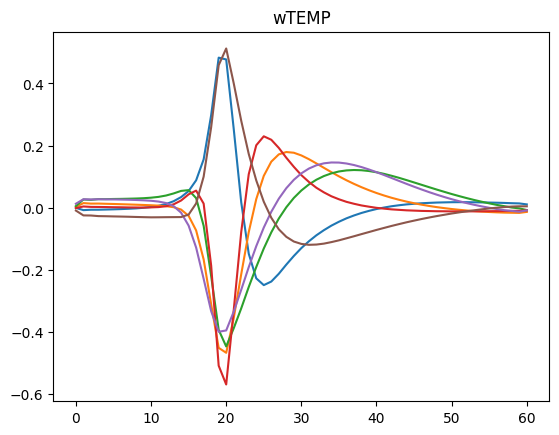

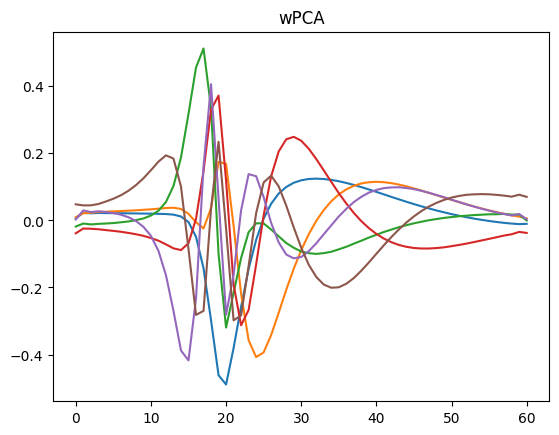

In [6]:
# get templates and PCs
sig = ops['settings']['min_template_size']
nsizes = ops['settings']['template_sizes'] 

if ops['settings']['templates_from_data']:
    logger.info('Re-computing universal templates from data.')
    # Determine templates and PC features from data.
    ops['wPCA'], ops['wTEMP'] = extract_wPCA_wTEMP(
        ops, bfile, nt=ops['nt'], twav_min=ops['nt0min'], 
        Th_single_ch=ops['settings']['Th_single_ch'], nskip=25,
        device=device
        )
else:
    logger.info('Using built-in universal templates.')
    # Use pre-computed templates.
    ops['wPCA'], ops['wTEMP'] = get_waves(ops, device=device)

plt.figure()
plt.plot(ops['wTEMP'].cpu().numpy().T)
plt.title('wTEMP')
plt.savefig(results_dir / 'wTEMP.png')
plt.figure()
plt.plot(ops['wPCA'].cpu().numpy().T)
plt.title('wPCA')
plt.savefig(results_dir / 'wPCA.png')    

In [7]:
# spikedetect.run()  
ops = template_centers(ops)
[ys, xs] = np.meshgrid(ops['yup'], ops['xup'])
ys, xs = ys.flatten(), xs.flatten()
xc, yc = ops['xc'], ops['yc']
Nfilt = len(ys)

nC = ops['settings']['nearest_chans']
nC2 = ops['settings']['nearest_templates']
iC, ds = nearest_chans(ys, yc, xs, xc, nC, device=device)

# Don't use templates that are too far away from nearest channel
# (use square of max distance since ds are squared distances)
igood = ds[0,:] <= ops['max_channel_distance']**2
iC = iC[:,igood]
ds = ds[:,igood]
ys = ys[igood]
xs = xs[igood]
ops['ycup'], ops['xcup'] = ys, xs

iC2, ds2 = nearest_chans(ys, ys, xs, xs, nC2, device=device)

ds_torch = torch.from_numpy(ds).to(device).float()
template_sizes = sig * (1+torch.arange(nsizes, device=device))
weigh = torch.exp(-ds_torch.unsqueeze(-1) / template_sizes**2)
weigh = torch.permute(weigh, (2, 0, 1)).contiguous()
weigh = weigh / (weigh**2).sum(1).unsqueeze(1)**.5

st_file = results_dir / 'st_temp.dat'
tF_file = results_dir / 'tF_temp.dat'

# delete the files if they exist
if st_file.exists():
    st_file.unlink()
if tF_file.exists():
    tF_file.unlink()

In [30]:
k = 0
nt = ops['nt']
tarange = torch.arange(-(nt//2),nt//2+1, device = device)
s = StringIO()
for ibatch in tqdm(np.arange(bfile.n_batches), miniters=200, mininterval=60):
    X = bfile.padded_batch_to_torch(ibatch, ops)

    xy, imax, amp, adist = template_match(X, ops, iC, iC2, weigh, device=device)
    yct = yweighted(yc, iC, adist, xy, device=device)
    nsp = len(xy)

    xsub = X[iC[:,xy[:,:1]], xy[:,1:2] + tarange]
    xfeat = xsub @ ops['wPCA'].T

    tf_this = xfeat.transpose(0,1).cpu().numpy()

    # convert tf_this to a one-dimensional array
    tf_this_flattened = tf_this.flatten()

    with open(tF_file, 'ab+') as f:
        f.write(tf_this_flattened.tobytes())

    st_this = np.zeros((nsp, 6), 'float64')
    st_this[:,0] = ((xy[:,1].cpu().numpy()-nt)/ops['fs'] + ibatch * (ops['batch_size']/ops['fs']))
    st_this[:,1] = yct.cpu().numpy()
    st_this[:,2] = amp.cpu().numpy()
    st_this[:,3] = imax.cpu().numpy()
    st_this[:,4] = ibatch
    st_this[:,5] = xy[:,0].cpu().numpy()

    # convert st_this to a one-dimensional array
    st_this_flattened = st_this.flatten()

    with open(st_file, 'ab+') as f:
        f.write(st_this_flattened.tobytes())

    k = k + nsp
    
    if progress_bar is not None:
        progress_bar.emit(int((ibatch+1) / bfile.n_batches * 100))

# st = np.fromfile(st_file, dtype='float64').reshape(-1, 6)
# tF = np.fromfile(tF_file, dtype='float32').reshape(-1, nC, ops['settings']['n_pcs'])

ops['iC'] = iC
ops['iC2'] = iC2
ops['weigh'] = weigh

del weigh, iC, iC2, ds, ds2, ys, xs, ds_torch

100%|██████████| 41870/41870 [7:01:17<00:00,  1.66it/s]  


In [31]:
np.save(results_dir / 'ops_temp.npy', ops, allow_pickle=True)

file_size = os.stat(st_file).st_size
nspk = int(file_size / 6 / 8)

In [33]:
nspk

407370291

In [3]:
ops = np.load(results_dir / 'ops_temp.npy', allow_pickle=True).item()
st_file = results_dir / 'st_temp.dat'
tF_file = results_dir / 'tF_temp.dat'

nC = ops['settings']['nearest_chans']

file_size = os.stat(st_file).st_size
nspk = int(file_size / 6 / 8)


c:\Users\jiumao\anaconda3\envs\spikeinterface2\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [4]:
# tF = torch.from_numpy(tF)
# logger.info(f'{nspk} spikes extracted in {time.time()-tic : .2f}s; ' + 
#             f'total {time.time()-tic0 : .2f}s')
# logger.debug(f'st0 shape: {st0.shape}')
# logger.debug(f'tF shape: {tF.shape}')
# if len(st0) == 0:
#     raise ValueError('No spikes detected, cannot continue sorting.')

tic = time.time()
logger.info(' ')
logger.info('First clustering')
logger.info('-'*40)

# clustering_qr.run()

# clu, Wall = clustering_qr.run(
#     ops, st0, tF, mode='spikes', device=device, progress_bar=progress_bar,
#     clear_cache=clear_cache
#     )

st = np.memmap(st_file, dtype='float64', mode='r', shape=(nspk, 6))
# st = np.fromfile(st_file, dtype='float64').reshape(nspk, 6)
tF = np.memmap(tF_file, dtype='float32', mode='r', shape=(nspk, nC, ops['settings']['n_pcs']))
# tF = torch.from_numpy(tF_memmap)

# xy, iC = xy_up(ops)
xy = np.vstack((ops['xcup'], ops['ycup']))
iC = ops['iC']
if isinstance(iC, torch.Tensor):
    iC = iC.cpu().numpy()

iclust_template = st[:,5].astype('int32')
xcup, ycup = ops['xcup'], ops['ycup']

dmin = ops['dmin']
dminx = ops['dminx']
nskip = ops['settings']['cluster_downsampling']
ycent = y_centers(ops)
xcent = x_centers(ops)
nsp = st.shape[0]

# Get positions of all grouping centers
ycent_pos, xcent_pos = np.meshgrid(ycent, xcent)
ycent_pos = ycent_pos.flatten()
xcent_pos = xcent_pos.flatten()
# ycent_pos = torch.from_numpy(ycent_pos.flatten())
# xcent_pos = torch.from_numpy(xcent_pos.flatten())
# Compute distances from templates
center_distance = (xy[0,:] - np.expand_dims(xcent_pos, axis=-1))**2 + (xy[1,:] - np.expand_dims(ycent_pos, axis=-1))**2
# Add some randomness in case of ties
center_distance += 1e-20*np.random.rand(*center_distance.shape)
# Get flattened index of x-y center that is closest to template
minimum_distance = np.argmin(center_distance, axis=0)

clu = np.zeros(nsp, 'int32')
Wall = np.zeros((0, ops['Nchan'], ops['settings']['n_pcs']))
nearby_chans_empty = 0
nmax = 0

In [5]:
kk = 0
jj = 0

# Get data for all templates that were closest to this x,y center.
ii = kk + jj*ycent.size
ix = (minimum_distance == ii)

# Xd, ch_min, ch_max, igood  = get_data_cpu(
#     ops, xy, iC, iclust_template, tF, ycent[kk], xcent[jj], dmin=dmin,
#     dminx=dminx, ix=ix
#     )
# def get_data_cpu(ops, xy, iC, PID, tF, ycenter, xcenter, dmin=20, dminx=32,
#          ix=None, merge_dim=True):
    
y0 = ycent[kk] # xy[1].mean() - ycenter
x0 = xcent[jj] #xy[0].mean() - xcenter

igood = ix[iclust_template].nonzero()[0]

pid = iclust_template[igood]

data = tF[igood]

nspikes, nchanraw, nfeatures = data.shape
ichan = np.unique(iC[:, ix])
ch_min = np.min(ichan)
ch_max = np.max(ichan)+1
nchan = ch_max - ch_min

dd = np.zeros((nspikes, nchan, nfeatures))
for j in tqdm(ix.nonzero()[0]):
    ij = np.nonzero(pid==j)[0]
    #print(ij.sum())
    dd[np.expand_dims(ij, axis=-1), iC[:,j]-ch_min] = data[ij]

Xd = np.reshape(dd, (nspikes, -1))

print('get_data_cpu() done!')

100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

get_data_cpu() done!


In [8]:
n_neigh = 10
nclust = 200
niter = 200
seed = 5
lam = 0

In [65]:
nskip=10
n_neigh=30

# subsampling the feature matrix 
Xsub = Xd[::nskip]

# n_samples is the number of spikes, dim is number of features
n_samples, dim = Xd.shape

# n_nodes are the # subsampled spikes
n_nodes = Xsub.shape[0]

# # search is much faster if array is contiguous
# Xd = np.ascontiguousarray(Xd)
# Xsub = np.ascontiguousarray(Xsub)

# exact neighbor search ("brute force")
# results is dn and kn, kn is n_samples by n_neigh, contains integer indices into Xsub
index = faiss.IndexFlatL2(dim)   # build the index
index.add(Xsub)    # add vectors to the index

print('start searching!')
_, kn = index.search(Xd, n_neigh)     # actual search
print('end searching!')

# create sparse matrix version of kn with ones where the neighbors are
# M is n_samples by n_nodes
dexp = np.ones(kn.shape, np.float32)    
rows = np.tile(np.arange(n_samples)[:, np.newaxis], (1, n_neigh)).flatten()
M   = csr_matrix((dexp.flatten(), (rows, kn.flatten())),
                (kn.shape[0], n_nodes))

# self connections are set to 0!
M[np.arange(0,n_samples,nskip), np.arange(n_nodes)] = 0

start searching!


KeyboardInterrupt: 

In [9]:
iclust_init =  kmeans_plusplus_numpy(torch.from_numpy(Xd).cpu(), niter = 200, seed = 1, device=torch.device('cpu'))

KeyboardInterrupt: 

In [17]:
Xd[::50].shape

(183882, 60)

In [ ]:
m, ki, kj = Mstats(M, device=device)

#Xg = torch.from_numpy(Xd).to(dev)
# kn = torch.from_numpy(kn).to(device)

n_neigh = kn.shape[1]
NN, nfeat = Xd.shape
nsub = (NN-1)//nskip + 1

rows_neigh = np.expand_dims(np.arange(NN), axis=-1).tile((1,n_neigh))

tones2 = np.ones((NN, n_neigh))

In [ ]:
# def kmeans_plusplus(Xg, niter = 200, seed = 1, device=torch.device('cuda')):
#Xg = torch.from_numpy(Xd).to(dev)    

vtot = (Xd**2).sum(1)

n1 = vtot.shape[0]
if n1 > 2**24:
    # Need to subsample v2, torch.multinomial doesn't allow more than 2**24
    # elements. We're just using this to sample some spikes, so it's fine to
    # not use all of them.
    n2 = n1 - 2**24   # number of spikes to remove before sampling
    remove = np.round(np.linspace(0, n1-1, n2)).astype(int)
    idx = np.ones(n1, dtype=bool)
    idx[remove] = False
    # Also need to map the indices from the subset back to indices for
    # the full tensor.
    rev_idx = idx.nonzero()[0]
    subsample = True
else:
    subsample = False

torch.manual_seed(seed)
np.random.seed(seed)

ntry = 100
NN, nfeat = Xd.shape    
mu = torch.zeros((niter, nfeat), device = device)
vexp0 = torch.zeros(NN,device = device)

iclust = torch.zeros((NN,), dtype = torch.int, device = device)
for j in tqdm(range(niter)):
    v2 = torch.relu(vtot - vexp0)
    if subsample:
        isamp = rev_idx[torch.multinomial(v2[idx], ntry)]
    else:
        isamp = torch.multinomial(v2, ntry)
    
    Xc = Xd[isamp]    
    vexp = 2 * Xd @ Xc.T - (Xc**2).sum(1)
    
    dexp = vexp - vexp0.unsqueeze(1)
    dexp = torch.relu(dexp)
    vsum = dexp.sum(0)

    imax = torch.argmax(vsum)
    ix = dexp[:, imax] > 0 

    mu[j] = Xd[ix].mean(0)
    vexp0[ix] = vexp[ix,imax]
    iclust[ix] = j


In [54]:
# iclust, iclust0, M, iclust_init = cluster(Xd, nskip=nskip, lam=1,
#                                                         seed=5, device=device)
# def cluster(Xd, iclust = None, kn = None, nskip = 20, n_neigh = 10, nclust = 200, 
#             seed = 1, niter = 200, lam = 0, device=torch.device('cuda')):    

# n_neigh = 10
# nclust = 200
# niter = 200
# seed = 5
# lam = 0

# kn, M = neigh_mat(Xd, nskip = nskip, n_neigh = n_neigh)

# m, ki, kj = Mstats(M, device=device)

# #Xg = torch.from_numpy(Xd).to(dev)
# kn = torch.from_numpy(kn).to(device)

# n_neigh = kn.shape[1]
# NN, nfeat = Xd.shape
# nsub = (NN-1)//nskip + 1

# rows_neigh = torch.arange(NN, device = device).unsqueeze(-1).tile((1,n_neigh))

# tones2 = torch.ones((NN, n_neigh), device = device)


iclust_init =  kmeans_plusplus(Xd, niter = nclust, seed = seed, device=device)
iclust = iclust_init.clone()

    
for t in tqdm(range(niter)):
    # given iclust, reassign isub
    isub = assign_isub(iclust, kn, tones2, nclust , nsub, lam, m,ki,kj, device=device)

    # given mu and isub, reassign iclust
    iclust = assign_iclust(rows_neigh, isub, kn, tones2, nclust, lam, m, ki, kj, device=device)

_, iclust = torch.unique(iclust, return_inverse=True)    
nclust = iclust.max() + 1
isub = assign_isub(iclust, kn, tones2, nclust , nsub, lam, m,ki,kj, device=device)

iclust = iclust.cpu().numpy()
isub = isub.cpu().numpy()

KeyboardInterrupt: 

In [ ]:
for kk in tqdm(np.arange(len(ycent)), miniters=20, mininterval=10):
    for jj in np.arange(len(xcent)):
        # Get data for all templates that were closest to this x,y center.
        ii = ii = kk + jj*ycent.size
        ix = (minimum_distance == ii)

        # Xd, ch_min, ch_max, igood  = get_data_cpu(
        #     ops, xy, iC, iclust_template, tF, ycent[kk], xcent[jj], dmin=dmin,
        #     dminx=dminx, ix=ix
        #     )
        # def get_data_cpu(ops, xy, iC, PID, tF, ycenter, xcenter, dmin=20, dminx=32,
        #          ix=None, merge_dim=True):
            
        y0 = ycent[kk] # xy[1].mean() - ycenter
        x0 = xcent[jj] #xy[0].mean() - xcenter

        igood = ix[iclust_template].nonzero()[:,0]

        pid = iclust_template[igood]

        data = tF[igood]

        nspikes, nchanraw, nfeatures = data.shape
        ichan = np.unique(iC[:, ix])
        ch_min = np.min(ichan)
        ch_max = np.max(ichan)+1
        nchan = ch_max - ch_min

        dd = np.zeros((nspikes, nchan, nfeatures))
        for j in ix.nonzero()[:,0]:
            ij = np.nonzero(pid==j)[:, 0]
            #print(ij.sum())
            dd[ij.unsqueeze(-1), iC[:,j]-ch_min] = data[ij]

        Xd = np.reshape(dd, (nspikes, -1))

        print('get_data_cpu() done!')


        if Xd is None:
            nearby_chans_empty += 1
            continue
        elif Xd.shape[0]<1000:
            iclust = np.zeros((Xd.shape[0],))
        else:
            st0 = None

            # find new clusters
            iclust, iclust0, M, iclust_init = cluster(Xd, nskip=nskip, lam=1,
                                                        seed=5, device=device)

            xtree, tstat, my_clus = hierarchical.maketree(M, iclust, iclust0)

            xtree, tstat = swarmsplitter.split(
                Xd.numpy(), xtree, tstat,iclust, my_clus, meta=st0
                )

            iclust = swarmsplitter.new_clusters(iclust, my_clus, xtree, tstat)

        clu[igood] = iclust + nmax
        Nfilt = int(iclust.max() + 1)
        nmax += Nfilt

        # we need the new templates here         
        W = torch.zeros((Nfilt, ops['Nchan'], ops['settings']['n_pcs']))
        for j in range(Nfilt):
            w = Xd[iclust==j].mean(0)
            W[j, ch_min:ch_max, :] = torch.reshape(w, (-1, ops['settings']['n_pcs'])).cpu()
        
        Wall = torch.cat((Wall, W), 0)

del Xd, W, Xd, ch_min, ch_max, igood, iclust, iclust0, M, iclust_init, xtree, tstat, my_clus

In [ ]:
Wall3 = template_matching.postprocess_templates(Wall, ops, clu, st0, device=device)
logger.info(f'{clu.max()+1} clusters found, in {time.time()-tic : .2f}s; ' +
            f'total {time.time()-tic0 : .2f}s')
logger.debug(f'clu shape: {clu.shape}')
logger.debug(f'Wall shape: {Wall.shape}')

tic = time.time()
logger.info(' ')
logger.info('Extracting spikes using cluster waveforms')
logger.info('-'*40)
st, tF, ops = template_matching.extract(ops, bfile, Wall3, device=device,
                                                progress_bar=progress_bar)
logger.info(f'{len(st)} spikes extracted in {time.time()-tic : .2f}s; ' +
            f'total {time.time()-tic0 : .2f}s')
logger.debug(f'st shape: {st.shape}')
logger.debug(f'tF shape: {tF.shape}')
logger.debug(f'iCC shape: {ops["iCC"].shape}')
logger.debug(f'iU shape: {ops["iU"].shape}')

In [ ]:
clu, Wall = cluster_spikes(
    st, tF, ops, device, bfile, tic0=tic0, progress_bar=progress_bar,
    clear_cache=clear_cache
    )
ops, similar_templates, is_ref, est_contam_rate, kept_spikes = \
    save_sorting(
        ops, results_dir, st, clu, tF, Wall, bfile.imin, tic0,
        save_extra_vars=save_extra_vars,
        save_preprocessed_copy=save_preprocessed_copy
        )